In [3]:
import matplotlib.pyplot as plt
import os
import tqdm
import numpy as np
from importlib import reload
import pickle
import pandas as pd
import seaborn as sns
import random

import pygame

import GamePhysicsSim as GPS
import GamePhysicsSim.Pod as PodClass
from GamePhysicsSim.Config import conf,ROOT_DIR
import GamePhysicsSim.NN as NN
import GamePhysicsSim.Visualise as Visualise
import GamePhysicsSim.Utils as Utils


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn import preprocessing
# from sklearn.pipeline import Pipeline

Next we follow https://www.tensorflow.org/tutorials/keras/regression

### Generate data on which to train a single AI for starters

#### In case you want to reload some modules after changes

In [34]:
reload(GPS)
reload(GPS.PhysicalObjects)
reload(GPS.Utils)
reload(PodClass)
reload(GPS.Config)
reload(Utils)
reload(NN)

import GamePhysicsSim as GPS
import GamePhysicsSim.Pod as PodClass
from GamePhysicsSim.Config import conf,ROOT_DIR
import GamePhysicsSim.Utils as Utils

### Set paths

Note that "confdir" is a unique identifier for the kinds of configuration with respect to the physics parameters, and also works as a path identifier for the subsequent analysis.


In [5]:
confdir = conf['conf_version']

training_data_dir = os.path.join(ROOT_DIR,f'Models/{confdir}/TrainingData')
data_scaler_path = os.path.join(ROOT_DIR,f'Models/{confdir}/DataScalers')
model_save_path = os.path.join(ROOT_DIR,f'Models/{confdir}')

if not os.path.exists(data_scaler_path):
    os.makedirs(data_scaler_path)

In [6]:
x_train = pd.read_csv(f'{training_data_dir}/train_data_errors_v1.csv',names=['vx','vy','w','delta_x','delta_y','delta_theta'])
y_train = pd.read_csv(f'{training_data_dir}/train_data_response_v1.csv',names=['Thrust','Torque'])

x_train contains output from pod.getPodSteeringStats(dt) = vx,vy,w,delta_x,delta_y,delta_theta.

vx, vy = velocity in x and y direction
w = angular velocity
delta_x,delta_y = distance from destination in x and y
delta_theta = angle to destination

Yes, there is a bit of degeneracy here with delta_x, delta_y and delta_theta. This should be cleaned up later if needed.

## Train model on these data to use as a nominal model for our AI

### Create and save a scaler for the data. Also scale data

In [121]:
data_scaler_x = preprocessing.StandardScaler().fit(x_train.values)
x_train_scaled = data_scaler_x.transform(x_train)

# data_scaler_y = preprocessing.StandardScaler().fit(y_train.values)
# y_train_scaled = data_scaler_y.transform(y_train)

scaler_file = os.path.join(data_scaler_path,'scaler_x.pkl')
pickle.dump(data_scaler, open(scaler_file, 'wb'))

# scaler_file = os.path.join(data_scaler_path,'scaler_y.pkl')
# pickle.dump(data_scaler, open(scaler_file, 'wb'))

### Let's look at the data

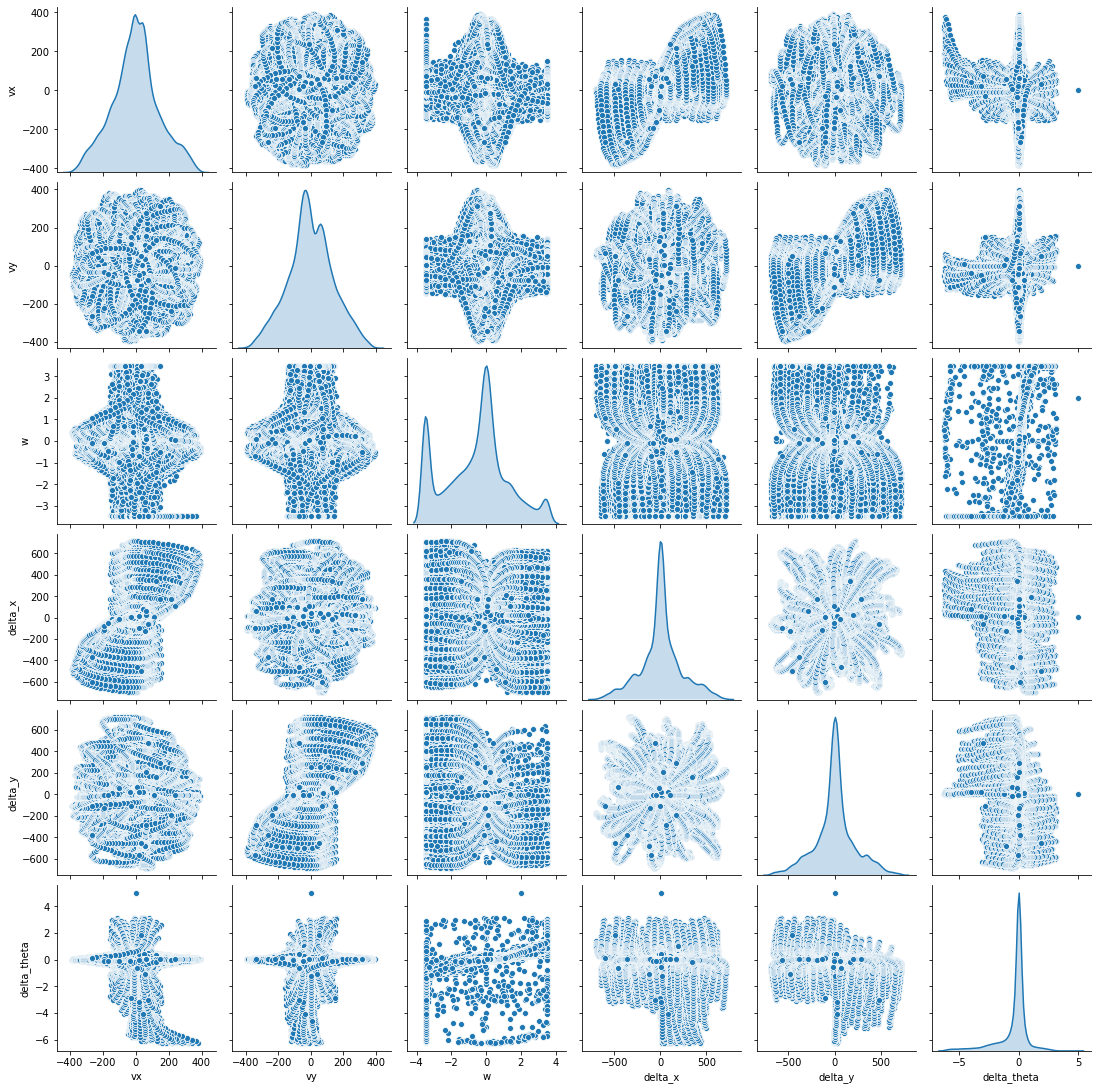

In [93]:
ax = sns.pairplot(x_train, diag_kind='kde')

In [101]:
x_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vx,36021.0,1.065993,140.834252,-382.583329,-85.634873,0.000000,80.296104,389.623102
vy,36021.0,-0.048312,138.153451,-392.374520,-84.528625,-5.369567,88.782656,396.585633
w,36021.0,-0.567364,1.834403,-3.490659,-1.901497,-0.230871,0.412948,3.490659
delta_x,36021.0,10.655398,222.754004,-694.635344,-91.763879,9.013514,110.049541,710.899983
delta_y,36021.0,6.963219,213.081300,-683.772634,-88.353499,7.253142,94.437582,718.399000
delta_theta,36021.0,-0.366819,1.225591,-6.272787,-0.400214,-0.019531,0.124976,5.000000


In [102]:
y_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Thrust,36021.0,19587.099834,19042.748307,0.0,4135.553771,12764.476637,31640.942097,85188.599321
Torque,36021.0,-3.570569,10.962624,-30.0,-5.350570,-0.229876,0.581022,30.000000


### Create and compile NN

In [103]:
model = keras.Sequential([
keras.layers.Flatten(input_shape=(6,)),
keras.layers.Dense(units=64,kernel_regularizer=keras.regularizers.l2(0.1), activation='relu'),
# keras.layers.Dropout(0.2),
keras.layers.Dense(units=64,kernel_regularizer=keras.regularizers.l2(0.1), activation='relu'),
# keras.layers.Dropout(0.2),
keras.layers.Dense(units=2)
])

BATCH_SIZE = 500
STEPS_PER_EPOCH = len(x_train)/BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
          loss='mean_absolute_error',
          metrics=['accuracy'])

In [104]:
from tqdm.keras import TqdmCallback

history = model.fit(x_train_scaled, y_train.values, validation_split=0.2, epochs=50,
                      verbose=0, callbacks=[TqdmCallback(verbose=0)])

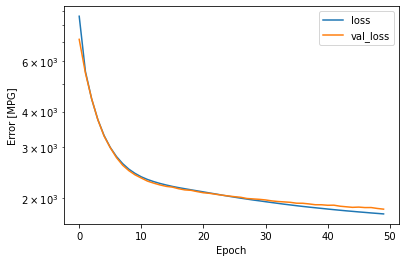

In [105]:
fig = NN.plot_loss(history)

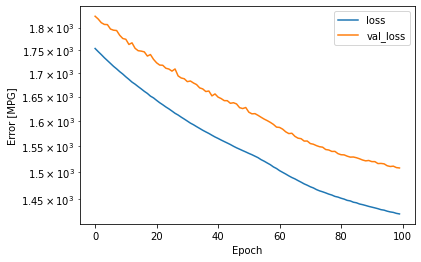

In [107]:
history_2 = model.fit(x_train_scaled, y_train.values,
                      validation_split=0.2,
                      verbose=0, epochs=100,
                      callbacks=[TqdmCallback(verbose=0)])
fig = NN.plot_loss(history_2)

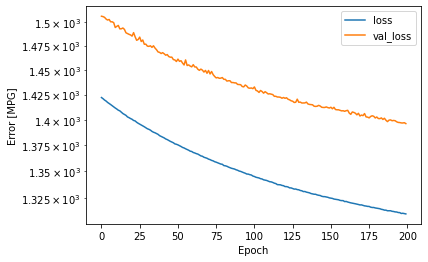

In [108]:
history3 = model.fit(x_train_scaled, y_train.values,
                    validation_split=0.2,
                    verbose=0, epochs=200,
                    callbacks=[TqdmCallback(verbose=0)])
fig = NN.plot_loss(history3)

In [122]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 130       
Total params: 4,738
Trainable params: 4,738
Non-trainable params: 0
_________________________________________________________________


In [126]:
mod_file = os.path.join(model_save_path,'Model_Gen0')
model.save(mod_file)

INFO:tensorflow:Assets written to: /Users/bjornahlgren/Documents/pythonModuleWorkShop/GamePhysicsSim/Models/conf1/Model_Gen0/assets


### Load model

In [52]:

mod_file = os.path.join(model_save_path,'Model_Gen0')

model1 = keras.models.load_model(mod_file,compile=True)

model1_nc = keras.models.load_model(mod_file,compile=False)

### Load scaler

In [53]:
scaler_file = os.path.join(data_scaler_path,'scaler_x.pkl')
scaler = pickle.load(open(scaler_file, 'rb'))

### Evaluate model on new data in test

In [54]:
%prun x_raw = x_train.values[np.random.choice(x_train.values.shape[0]),:]

In [55]:
%prun x_scaled = scaler.transform(x_raw.reshape(1,len(x_raw)))

In [65]:
%prun model1_nc(x_scaled)[0]

In [63]:
%prun model1.predict(x_scaled)

In [60]:
model1.predict?

In [ ]:
47893 function calls (47101 primitive calls) in 0.162 seconds

In [ ]:
1    0.059    0.059    0.059    0.059 {built-in method _pywrap_tensorflow_internal.TFE_Py_Execute}

In [ ]:
2700 function calls (2638 primitive calls) in 0.006 seconds

In [ ]:
4    0.001    0.000    0.001    0.000 {built-in method _pywrap_tensorflow_internal.TFE_Py_Execute}a

In [67]:
model(x_scaled)[0].numpy()

array([4.8582539e+04, 1.5639305e-02], dtype=float32)

In [261]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl

In [326]:
# def anim_init():
    
def animate(i,podList):
    for pod in podList:
        pod.patch.center = tuple(pod.pos)

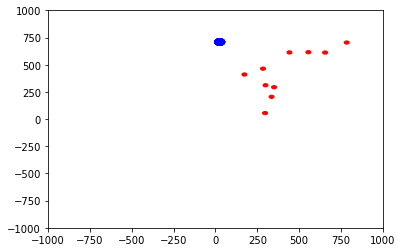

In [323]:
fig,ax = plt.subplots()
ax.set_xlim([-1000,1000])
ax.set_ylim([-1000,1000])
cpFigs = [plt.Circle(cp, CheckPointSize, color='r') for cp in checkpointList]
for j,pod in enumerate(podList):
    podPatch = plt.Circle((pod_pos)+(5*i,5*i), PODSIZE[0], color='b')
    pod.patch = podPatch
    ax.add_patch(podPatch)
# podFigs = [ for j,pod in enumerate(podList[-1:])] #fix unique colors for all pods!
# for podFig in podFigs:
#     ax.add_patch(podFig)
for cpFig in cpFigs:
    ax.add_artist(cpFig)

In [324]:
anim = FuncAnimation(fig,animate,frames = None,fargs=(podList,),
              blit=False)


In [325]:
HTML(anim.to_html5_video())

TypeError: animate() takes 1 positional argument but 2 were given

In [171]:
reload(GPS)
reload(GPS.PhysicalObjects)
reload(GPS.Utils)
reload(PodClass)
reload(GPS.Config)
reload(Utils)
reload(NN)

# import GamePhysicsSim as GPS
# import GamePhysicsSim.Pod as PodClass
# from GamePhysicsSim.Config import conf
# import GamePhysicsSim.Utils as Utils

<module 'GamePhysicsSim.NN' from '/Users/bjornahlgren/Documents/pythonModuleWorkShop/GamePhysicsSim/GamePhysicsSim/NN.py'>